# The score

Score-Based Models (SBM) are models of the log probability gradient, also called the score

$$ 
\mathbf{s}(\mathbf{x}) = \nabla_{\mathbf{x}} \log p(\mathbf{x})\,. 
$$

For an in-depth discussion of SBM's, I strongly suggest reading [Yang Song's blog post](https://yang-song.net/blog/2021/score/). 
This introduction is my own take on the subject.


## The normalization condition
First, a natural question that arises is: why not directly model the probability density function, $p(\mathbf{x})$? 
For a probability density function to be valid, it must be normalized over its domain $\mathcal{X}$

$$
    \int_{\mathcal{X}} p(\mathbf{x}) \mathrm{d}^n \mathbf{x} = 1\, .
$$

This, it turns out, is a very stringent condition. Not many functions have this property. 
Normalizing flows attempt to model probability densities by starting from a valid distribution, 
typically a Gaussian, and use a sequence of diffeomorphisms defined by neural networks 
with a tractable Jacobian to increase the expressivity of the model.
In this way, the normalization condition is guaranteed to be respected,
but the structure imposed on the neural network ultimately limits 
the expressivity and scalability of the framework to higher dimensional spaces.

Imposing the normalization condition as a soft-constraint (adding it to a loss function) is an obvious no-go. 
The integral is intractable in most cases of interest.
In general, 

$$\mathbf{x} \in \mathcal{X} \subseteq \mathbb{R}^n\,.$$ 

For images, $n > 10^4$ is typical. This is a problem.

## The score is local (for a Gibbs measure)
By targeting the score, we sidestep the normalization condition entirely. Indeed, 
a large class of distributions can be described by the Gibbs measure

$$
    p(\mathbf{x}) = \frac{1}{\mathcal{Z}} e^{- E(\mathbf{x}) }\, .
$$

All we did is to suppose the existence of an energy function, $E(\mathbf{x})$, 
which now describes the distribution, so to speak.
The normalization condition is encoded in the partition function

$$
    \mathcal{Z} = \int_\mathcal{X} e^{-E(\mathbf{x})} \mathrm{d}^n \mathbf{x}\, .
$$

Crucially, the score of a Gibbs measure is a purely local description of the distribution, 
independent of the partition function

$$
    \nabla_{\mathbf{x}} \log p(\mathbf{x}) = - \nabla_{\mathbf{x}} E(\mathbf{x})\, .
$$

By modeling the score using some neural network with parameters $\theta$, 
we can use any function with the following signature

$$
\mathbf{s}_\theta: \mathbb{R}^n \rightarrow \mathbb{R}^n\, .
$$

There is no other restriction on the architecture of the neural network, which allows us to use the full power of the 
universal approximation theorem for neural networks to model a distribution.

## Score of a Gaussian mixture

We can even extend the locality argument to a mixture of distribution, at least to some degree.
Let's consider a mixture of 4 well-separated Gaussian modes with equal weights.

In [1]:
!pip install --quiet score_models colorcet SciencePlots # For colab notebooks.
from score_models.plot_utils import *
from score_models.toy_distributions import *
from torch.func import grad, vmap

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
distribution = egg_box(4, mode_width=0.1, box_size=1)

def logp(x):
    return distribution.log_prob(x)

def score(x):
    return vmap(grad(logp))(x)

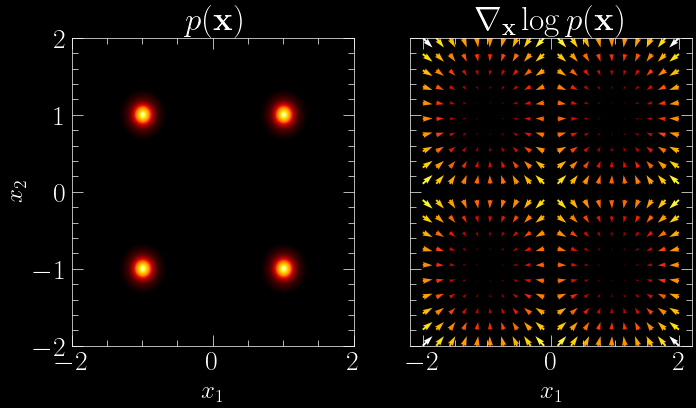

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

ax = axs[0]
plot_density(logp, ax=ax)
ax.set_title(r"$p(\mathbf{x})$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

ax = axs[1]
plot_score(score, ax=ax)
ax.set_title(r"$\nabla_{\mathbf{x}} \log p(\mathbf{x})$")
ax.set_xlabel(r"$x_1$");


The score is a vector field pointing toward regions of higher density. The farther from these regions, the larger the magnitude of the score. But, since the score is local, the magnitude does not depend on the relative magnitude of the mode.

To show this, we can change the weights of each mode. This changes the probability density picture on the left, obviously. 
But, the magnitude and orientation of the score field picture on the right does not change.

In [4]:
distribution = egg_box(4, mode_width=0.1, box_size=1, weights=(1, 0.5, 0.5, 0.1))

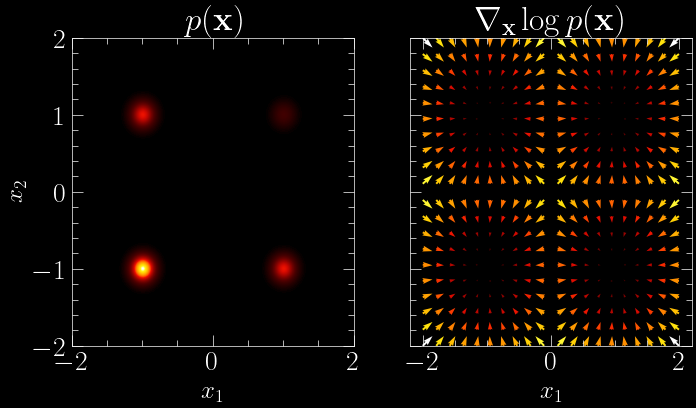

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

ax = axs[0]
plot_density(logp, ax=ax)
ax.set_title(r"$p(\mathbf{x})$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

ax = axs[1]
plot_score(score, ax=ax)
ax.set_title(r"$\nabla_{\mathbf{x}} \log p(\mathbf{x})$")
ax.set_xlabel(r"$x_1$");


Of course, there is nothing magical about this.
Using $w_i$ as weights, we can write the Gaussian mixture as

$$
    p(\mathbf{x}) = \frac{1}{\mathcal{Z}}\sum_{i}w_i e^{-E_i(\mathbf{x}) }\, ,
$$

where $E_i(\mathbf{x}) = \frac{1}{2\sigma^2} \big\lVert \mathbf{x} - \boldsymbol{\mu}_i \big\rVert^2_2$ for a Gaussian distribution. The score becomes,

$$
    \nabla_{\mathbf{x}} \log p(\mathbf{x}) = \nabla_{\mathbf{x}} \log \left(\sum_{i}w_i e^{-E_i(\mathbf{x}) } \right)\, .
$$

If the modes are *well separated*, only a single mode will contribute to the sum inside the $\log$. 
The contribution from other modes vanishes exponentially fast. 
Thus, we are left with only the dominant mode in the sum (say mode $j$)

$$
    \sum_{i}w_i e^{-E_i(\mathbf{x}) } \approx w_j e^{-E_j(\mathbf{x}) }\, .
$$

The score becomes

$$
    \nabla_{\mathbf{x}} \log p(\mathbf{x}) \approx -\nabla_\mathbf{x} E_j (\mathbf{x})\, .
$$

Crucially, we find that the score around the dominant mode does not depend on the weight of this mode nor the global normalization of the distribution.


## Score of an annealed mixture of Gaussian

This is not to say that the score never depends on the relative weights of the modes. If we anneal each modes by increasing their width, we notice that the score field starts to picks up the relative importance of each mode. This is especially noticable for the mode in the top-right corner. With our choice of annealing, this mode has disappeared and the score there points away from the mode toward the other 3. 

In [6]:
distribution = egg_box(4, mode_width=0.8, box_size=1, weights=(1, 0.5, 0.5, 0.1))

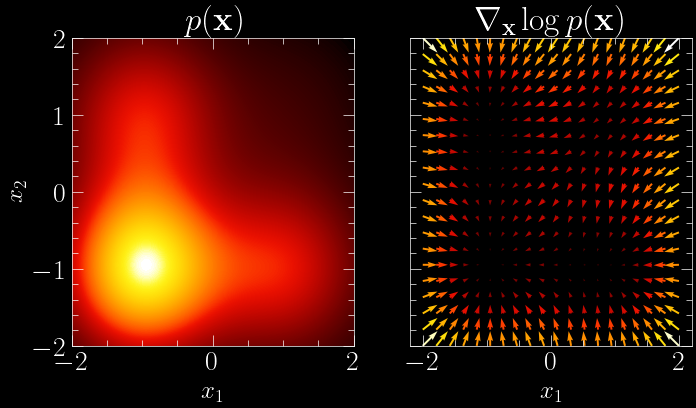

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

ax = axs[0]
plot_density(logp, ax=ax)
ax.set_title(r"$p(\mathbf{x})$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

ax = axs[1]
plot_score(score, ax=ax, scale=30)
ax.set_title(r"$\nabla_{\mathbf{x}} \log p(\mathbf{x})$")
ax.set_xlabel(r"$x_1$");


## Conclusion

We have seen that
- For well-separated modes, the score is local;
- We can recover the weight of each mode using annealing.

These two facts alone should give enough intuition for the next sections:
1) Training an SBM with [score matching](./02-score_matching.ipynb);
2) Sampling with [diffusion](./03-diffusion.ipynb).

The score models package also offer some more utilities to
- Train a [conditional SBM](./04-conditional_sbm.ipynb);
- Compute [log probability](./05-log_prob.ipnyb);
- [Fine-tuning](./06-lora.ipnyb) of SBM's with LoRA weights.